In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [13]:
df = pd.read_csv('../data/clean_reclean/time_series.csv')

# Création de la colonne datetime
df['Date'] = pd.to_datetime(df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01')

# Agrégation mensuelle
monthly_avg = df.groupby('Date')['SalePrice'].mean().reset_index()
monthly_avg.columns = ['Date', 'AverageSalePrice']

# Mise en index datetime
monthly_avg.set_index('Date', inplace=True)
monthly_avg.index.name = 'Date'

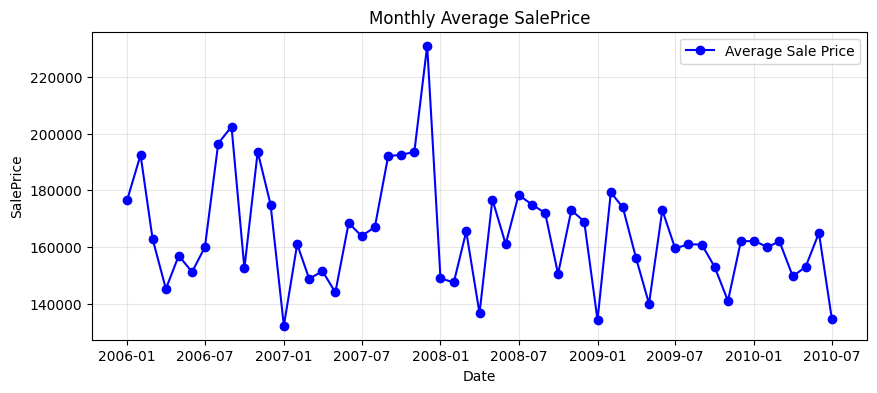

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(monthly_avg, label='Average Sale Price', marker='o', linestyle='-', color='blue')
plt.grid(True, alpha=0.3)
plt.title('Monthly Average SalePrice')
plt.xlabel('Date')
plt.ylabel('SalePrice')
plt.legend()
plt.show()


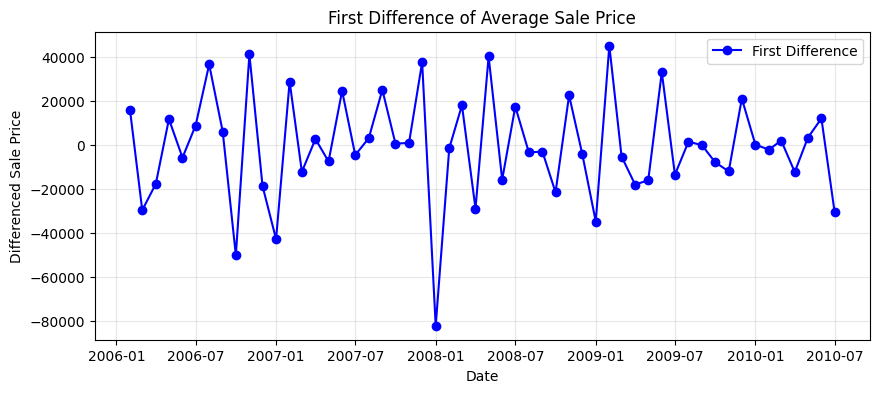

In [4]:
monthly_diff = monthly_avg['AverageSalePrice'].diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(monthly_diff, label='First Difference', marker='o', linestyle='-', color='blue')
plt.grid(True, alpha=0.3)
plt.title('First Difference of Average Sale Price')
plt.xlabel('Date')
plt.ylabel('Differenced Sale Price')
plt.legend()
plt.show()

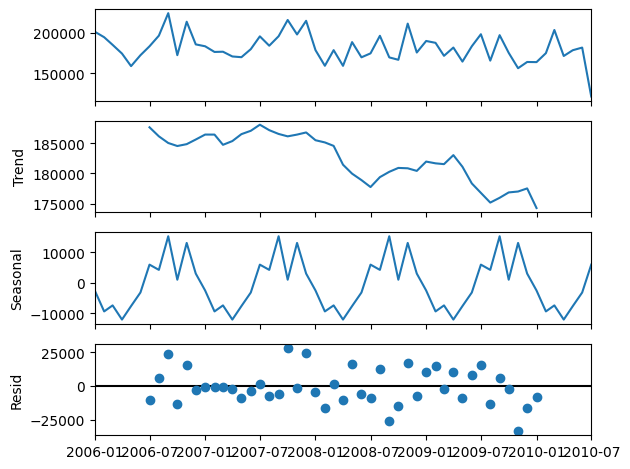

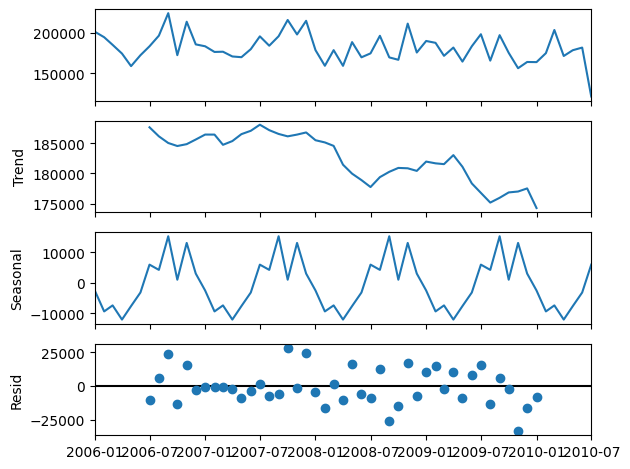

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_add = seasonal_decompose(monthly_avg, model='additive')
decomp_add.plot()

In [5]:
X_orig = np.arange(len(monthly_avg)).reshape(-1, 1)
X_orig_const = sm.add_constant(X_orig)
y_orig = monthly_avg['AverageSalePrice'].values
model_orig = sm.OLS(y_orig, X_orig_const).fit()
original_p_values = model_orig.pvalues[1]
print(f"Original series trend p-value: {original_p_values:.4f}")

Original series trend p-value: 0.0660


In [6]:
log_avg = np.log(monthly_avg['AverageSalePrice'])
log_diff = log_avg.diff().dropna()

X_log_diff = np.arange(len(log_diff)).reshape(-1, 1)
X_log_diff_const = sm.add_constant(X_log_diff)
y_log_diff = log_diff.values
model_log_diff = sm.OLS(y_log_diff, X_log_diff_const).fit()
log_diff_p_value = model_log_diff.pvalues[1]
print(f"Log-differenced series trend p-value: {log_diff_p_value:.4f}")

Log-differenced series trend p-value: 0.8511


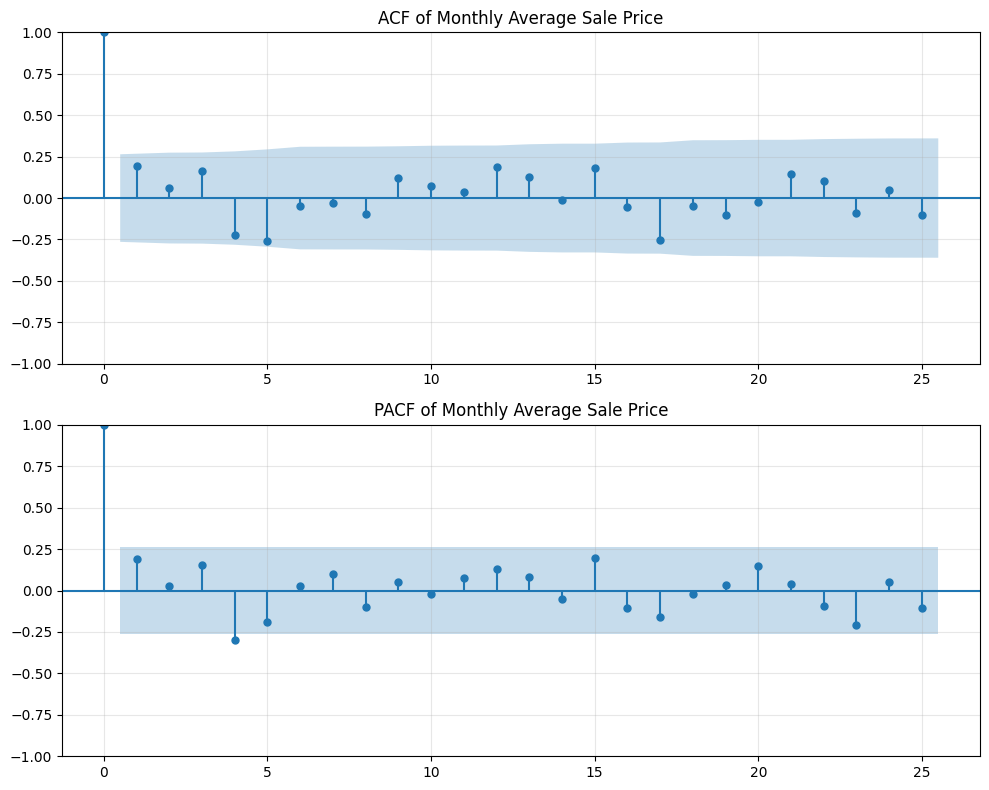

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(monthly_avg, lags=25, ax=axes[0])
axes[0].set_title('ACF of Monthly Average Sale Price')
axes[0].grid(True, alpha=0.3)

plot_pacf(monthly_avg, lags=25, ax=axes[1])
axes[1].set_title('PACF of Monthly Average Sale Price')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
print(monthly_avg)

            AverageSalePrice
Date                        
2006-01-01          176700.0
2006-02-01          192500.0
2006-03-01          162900.0
2006-04-01          145250.0
2006-05-01          156950.0
2006-06-01          151200.0
2006-07-01          160000.0
2006-08-01          196500.0
2006-09-01          202500.0
2006-10-01          152500.0
2006-11-01          193605.0
2006-12-01          175000.0
2007-01-01          132250.0
2007-02-01          161000.0
2007-03-01          148800.0
2007-04-01          151500.0
2007-05-01          144000.0
2007-06-01          168500.0
2007-07-01          163900.0
2007-08-01          167000.0
2007-09-01          192000.0
2007-10-01          192570.5
2007-11-01          193500.0
2007-12-01          231000.0
2008-01-01          149000.0
2008-02-01          147500.0
2008-03-01          165500.0
2008-04-01          136625.0
2008-05-01          176750.0
2008-06-01          161000.0
2008-07-01          178400.0
2008-08-01          175000.0
2008-09-01    

In [9]:
# from pmdarima import auto_arima

# model = auto_arima(
#     monthly_avg,
#     seasonal=True,
#     m=12,  # Monthly data
#     trace=True,
#     error_action='ignore',
#     suppress_warnings=True,
#     stepwise=True
# )

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# #Split dataset,
 n = len(monthly_avg)
# split = int(n * 0.8)  # 80% for training, 20% for testing
# split2 = int(n * 0.2) 
# train = pd.concat([monthly_avg.iloc[:split2], monthly_avg.iloc[split:]])
# test = monthly_avg.iloc[split2:split]

split = int(n * 0.8)  # 80% for training, 20% for testing
train = monthly_avg
test = monthly_avg.iloc[split:]

#Specify combinations,
# Specify combinations
non_seasonal_orders = [
    (1,1,1), (2,1,1), (1,1,0)
]

seasonal_orders = [
    (1,1,1,12), (1,1,0,12), (0,1,1,12), (0,1,0,12),
    (0,0,0,12), (2,0,1,12)
]

# Dictionary to hold results,
results = {}

# Loop over combinations,
for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        history = train.copy()

        for t in range(len(test)):
            model = SARIMAX(history,
                            order=ns_order,
                            seasonal_order=s_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit(disp=False)

            forecast = model.forecast(steps=1).iloc[0]
            actual = test['AverageSalePrice'].iloc[t]

            preds.append(forecast)
            actuals.append(actual)

            # Update history with actual
            history = pd.concat([history, test.iloc[[t]]])

        errors = np.array(actuals) - np.array(preds)
        var_error = np.var(errors)

        results[label] = {
            'Forecasts': preds,
            'Actuals': actuals,
            'Errors': errors,
            'Variance of Forecast Error': var_error
        }

# Create summary DataFrame and get best two models,
summary_df = pd.DataFrame([
    {'Model': name, 'Forecast Error Variance': res['Variance of Forecast Error']}
    for name, res in results.items()
]).sort_values('Forecast Error Variance').reset_index(drop=True)



print(summary_df)
# Plot only top 2 models,
for name in summary_df['Model'][:2]:
    res = results[name]
    # Ensure both x and y are numpy arrays of the same length
    x = test.index.values[:len(res['Actuals'])]
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])
    print(forecasts)
    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    


IndentationError: unexpected indent (416091348.py, line 4)

/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begi

                                   Model  Forecast Error Variance          AIC
0   ARIMA(1, 1, 1) x SARIMA(1, 1, 1, 12)                      NaN   314.085513
1   ARIMA(1, 1, 1) x SARIMA(1, 1, 0, 12)                      NaN   286.211453
2   ARIMA(1, 1, 1) x SARIMA(0, 1, 1, 12)                      NaN   348.815708
3   ARIMA(1, 1, 1) x SARIMA(0, 1, 0, 12)                      NaN   529.780887
4   ARIMA(1, 1, 1) x SARIMA(0, 0, 0, 12)                      NaN   798.208085
5   ARIMA(1, 1, 1) x SARIMA(1, 0, 0, 12)                      NaN   545.594294
6   ARIMA(1, 1, 1) x SARIMA(1, 0, 1, 12)                      NaN  2854.314904
7   ARIMA(2, 1, 1) x SARIMA(1, 1, 1, 12)                      NaN   277.889736
8   ARIMA(2, 1, 1) x SARIMA(1, 1, 0, 12)                      NaN   268.676803
9   ARIMA(2, 1, 1) x SARIMA(0, 1, 1, 12)                      NaN   313.463739
10  ARIMA(2, 1, 1) x SARIMA(0, 1, 0, 12)                      NaN   531.129923
11  ARIMA(2, 1, 1) x SARIMA(0, 0, 0, 12)            

/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipykernel_1061/1118985868.py:47: RuntimeWarning: overflow encountered in exp
  preds.append(np.exp(forecast))
/tmp/ipykernel_1061/1118985868.py:48: RuntimeWarning: overflow encountered in exp
  actuals.append(np.exp(actual))
/tmp/ipykernel_1061/1118985868.py:58: RuntimeWarning: invalid value encountered in subtract
  errors = np.array(actuals) - np.array(preds)


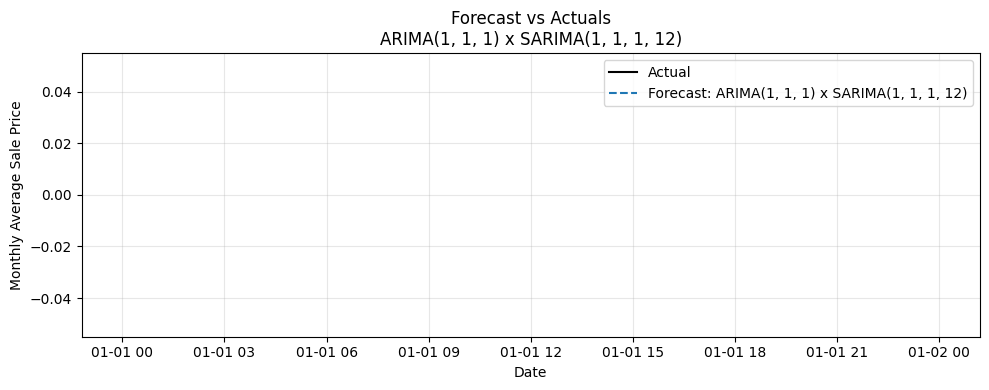

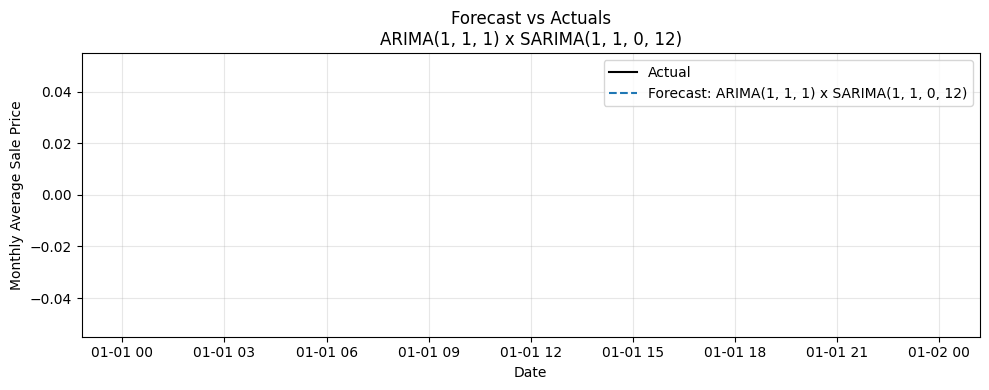

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming 'monthly_avg' is a DataFrame with a datetime index and a column named 'AverageSalePrice'
# Make sure the index is datetime formatted
monthly_avg.index = pd.to_datetime(monthly_avg.index)

# Split dataset
n = len(monthly_avg)
split = int(n * 0.8)
split2 = int(n * 0.2)

train = pd.concat([monthly_avg.iloc[:split2], monthly_avg.iloc[split:]])
test = monthly_avg.iloc[split2:split]

# Specify combinations
non_seasonal_orders = [
    (1,1,1), (2,1,1), (1,1,0)
]

seasonal_orders = [
    (1,1,1,12), (1,1,0,12), (0,1,1,12), (0,1,0,12),
    (0,0,0,12), (1,0,0,12), (1,0,1,12),
]

# Dictionary to hold results
results = {}

for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        aics = []
        history = train.copy()

        for t in range(len(test)):
            try:
                model = SARIMAX(history,
                                order=ns_order,
                                seasonal_order=s_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
                forecast = model.forecast(steps=1).iloc[0]
                actual = test['AverageSalePrice'].iloc[t]

                # Invert log for both forecast and actual
                preds.append(np.exp(forecast))
                actuals.append(np.exp(actual))
                aics.append(model.aic)

                # Update history with actual
                history = pd.concat([history, test.iloc[[t]]])
            except Exception as e:
                print(f"Model {label} failed: {e}")
                break

        if len(actuals) > 0:
            errors = np.array(actuals) - np.array(preds)
            var_error = np.var(errors)
            avg_aic = np.mean(aics) if aics else np.nan
            results[label] = {
                'Forecasts': preds,
                'Actuals': actuals,
                'Errors': errors,
                'Variance of Forecast Error': var_error,
                'AIC': avg_aic
            }

# Create summary DataFrame and get best two models
summary_df = pd.DataFrame([
    {
        'Model': name,
        'Forecast Error Variance': res['Variance of Forecast Error'],
        'AIC': res['AIC']
    }
    for name, res in results.items()
]).sort_values('Forecast Error Variance').reset_index(drop=True)

print(summary_df[['Model', 'Forecast Error Variance', 'AIC']])

# Plot only top 2 models
for name in summary_df['Model'][:2]:
    res = results[name]
    x = test.index[:len(res['Actuals'])]  # Ensure x matches the length of actuals/forecasts
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])

    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return

                                   Model  Forecast Error Variance        AIC
0   ARIMA(1, 1, 1) x SARIMA(1, 1, 0, 12)             4.799895e+08 -12.461491
1   ARIMA(2, 1, 1) x SARIMA(0, 0, 0, 12)             4.814568e+08 -43.674106
2   ARIMA(1, 1, 1) x SARIMA(0, 0, 0, 12)             4.925292e+08 -44.255108
3   ARIMA(1, 1, 0) x SARIMA(1, 1, 0, 12)             4.938259e+08 -12.470066
4   ARIMA(1, 1, 0) x SARIMA(0, 0, 0, 12)             5.200591e+08 -43.518470
5   ARIMA(1, 1, 0) x SARIMA(1, 1, 1, 12)             5.248378e+08 -10.678012
6   ARIMA(1, 1, 1) x SARIMA(1, 1, 1, 12)             5.495760e+08  -8.392290
7   ARIMA(1, 1, 0) x SARIMA(2, 1, 1, 12)             6.038884e+08   0.072411
8   ARIMA(1, 1, 1) x SARIMA(2, 1, 1, 12)             6.883504e+08   0.481062
9   ARIMA(2, 1, 1) x SARIMA(1, 1, 1, 12)             6.956804e+08  -6.389384
10  ARIMA(2, 1, 1) x SARIMA(1, 1, 0, 12)             8.106091e+08  -9.603713
11  ARIMA(2, 1, 1) x SARIMA(2, 1, 1, 12)             8.833575e+08   4.961109

/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


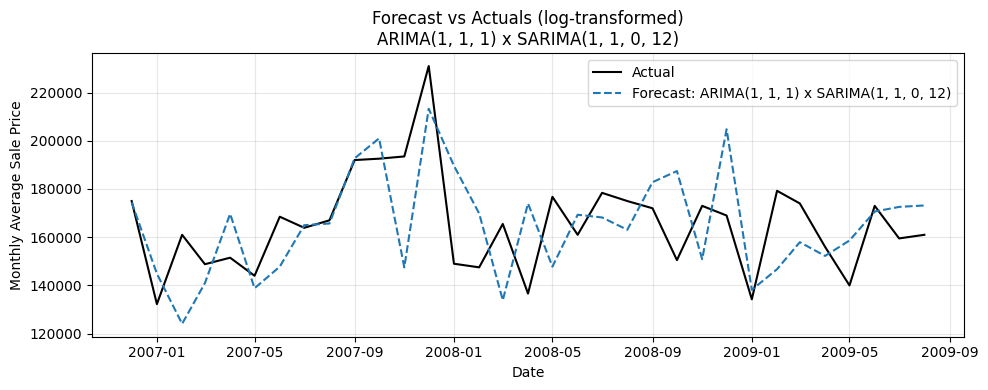

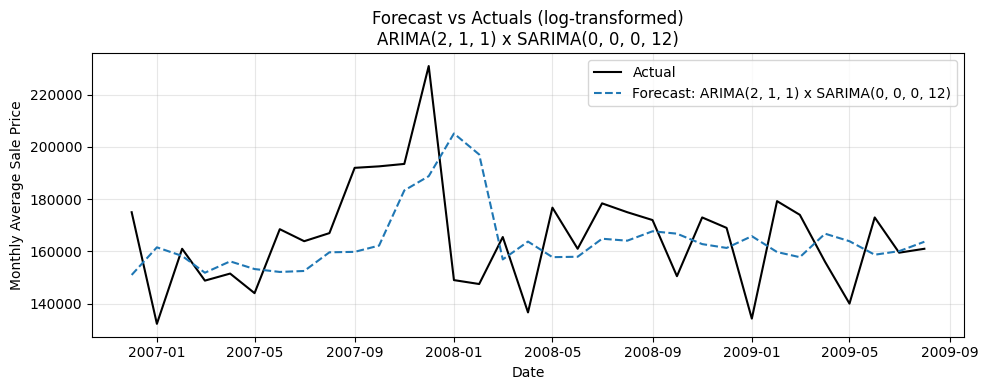

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Log-transform the data
log_monthly_avg = np.log(monthly_avg['AverageSalePrice'])
log_monthly_avg = log_monthly_avg.to_frame(name='LogAverageSalePrice')

# Split dataset
n = len(log_monthly_avg)
split = int(n * 0.8)
split2 = int(n * 0.2)
train = pd.concat([log_monthly_avg.iloc[:split2], log_monthly_avg.iloc[split:]])
test = log_monthly_avg.iloc[split2:split]

# split = int(n * 0.8)  # 80% for training, 20% for testing
# train = log_monthly_avg
# test = log_monthly_avg.iloc[split:]


# Specify combinations
non_seasonal_orders = [
    (1,1,1), (2,1,1), (1,1,0)
  
]
seasonal_orders = [
    (0,0,0,12), (1,1,1,12), (1,1,0,12), (2,1,1,12)
]

results = {}

for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        aics = []
        history = train.copy()

        for t in range(len(test)):
            try:
                model = SARIMAX(history,
                                order=ns_order,
                                seasonal_order=s_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
                forecast_log = model.forecast(steps=1).iloc[0]
                actual_log = test['LogAverageSalePrice'].iloc[t]

                # Invert log for both forecast and actual
                preds.append(np.exp(forecast_log))
                actuals.append(np.exp(actual_log))
                aics.append(model.aic)

                # Update history with actual
                history = pd.concat([history, test.iloc[[t]]])
            except Exception as e:
                print(f"Model {label} failed: {e}")
                break

        if len(actuals) > 0:
            errors = np.array(actuals) - np.array(preds)
            var_error = np.var(errors)
            avg_aic = np.mean(aics) if aics else np.nan
            results[label] = {
                'Forecasts': preds,
                'Actuals': actuals,
                'Errors': errors,
                'Variance of Forecast Error': var_error,
                'AIC': avg_aic
            }

# Create summary DataFrame and get best two models
summary_df = pd.DataFrame([
    {
        'Model': name,
        'Forecast Error Variance': res['Variance of Forecast Error'],
        'AIC': res['AIC']
    }
    for name, res in results.items()
]).sort_values('Forecast Error Variance').reset_index(drop=True)

print(summary_df[['Model', 'Forecast Error Variance', 'AIC']])

# Plot only top 2 models
for name in summary_df['Model'][:2]:
    res = results[name]
    x = test.index.values[:len(res['Actuals'])]
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])
    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals (log-transformed)\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()